In [51]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
sns.set_style('darkgrid')
np.random.seed(42)

In [52]:
idx = pd.IndexSlice
with pd.HDFStore('data/assets.h5') as store:
    stocks = store['us_equities/stocks'].marketcap.nlargest(30) # only for 30 biggest firms
    returns = (store['quandl/wiki/prices'].loc[idx['2010': '2018', stocks.index], 'adj_close']
               .unstack('ticker').pct_change())

In [53]:
# winsorizing and normalization of returns
# scale() : Standard Normal Gaussian
normed_returns = scale(returns.clip(lower=returns.quantile(q=.025), upper=returns.quantile(q=.975), axis=1)
                      .apply(lambda x: x.sub(x.mean()).div(x.std())))
returns = returns.dropna(thresh=int(returns.shape[0] * .95), axis=1)
returns = returns.dropna(thresh=int(returns.shape[1] * .95))
returns.info() # left 23 stocks by winsornizin

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2070 entries, 2010-01-05 to 2018-03-27
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    2070 non-null   float64
 1   AMZN    2070 non-null   float64
 2   BA      2070 non-null   float64
 3   BAC     2070 non-null   float64
 4   CSCO    2070 non-null   float64
 5   CVX     2070 non-null   float64
 6   GOOGL   2070 non-null   float64
 7   HD      2070 non-null   float64
 8   INTC    2070 non-null   float64
 9   JNJ     2070 non-null   float64
 10  JPM     2070 non-null   float64
 11  KO      2070 non-null   float64
 12  MA      2070 non-null   float64
 13  MSFT    2070 non-null   float64
 14  PFE     2070 non-null   float64
 15  PG      2070 non-null   float64
 16  T       2070 non-null   float64
 17  UNH     2070 non-null   float64
 18  V       2070 non-null   float64
 19  VZ      2070 non-null   float64
 20  WFC     2070 non-null   float64
 21  WMT     2070 non-nu

In [54]:
returns.tail()

ticker,AAPL,AMZN,BA,BAC,CSCO,CVX,GOOGL,HD,INTC,JNJ,...,MSFT,PFE,PG,T,UNH,V,VZ,WFC,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2018-03-21,-0.022655,-0.002931,-0.001570,-0.003440,-0.001352,0.022183,-0.001643,-0.000786,0.000194,-0.000152,...,-0.006979,-0.001652,-0.016218,-0.009356,-0.017462,-0.013530,-0.008597,-0.002004,0.002615,0.014191
2018-03-22,-0.014159,-0.023871,-0.051884,-0.041418,-0.027985,-0.028537,-0.037340,-0.015335,-0.014158,-0.029042,...,-0.029087,-0.018473,-0.008178,-0.017500,-0.034153,-0.026213,-0.008460,-0.041248,-0.011794,-0.020522
2018-03-23,-0.023128,-0.031436,0.004349,-0.045172,-0.015092,-0.006332,-0.025258,-0.019910,-0.028920,-0.017899,...,-0.029068,-0.031180,-0.006544,-0.018943,-0.012360,-0.024919,-0.012585,-0.029507,-0.019738,-0.008299
2018-03-26,0.047472,0.040319,0.024829,0.043538,0.038661,0.020977,0.026828,0.026659,0.063209,0.018305,...,0.075705,0.015947,0.006587,-0.000288,0.030675,0.031111,0.016850,0.025696,0.024350,0.015228
2018-03-27,-0.025641,-0.037799,-0.023862,-0.030223,-0.031321,-0.005982,-0.044731,-0.009638,-0.024581,-0.001413,...,-0.045959,-0.000856,0.018060,0.006054,-0.005067,-0.026857,0.005099,-0.022758,-0.016571,-0.004054


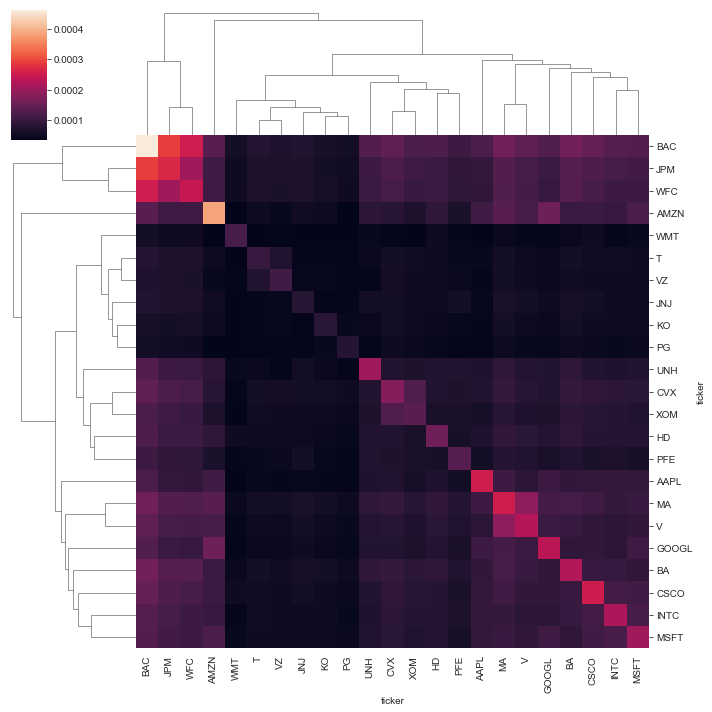

In [55]:
cov = returns.cov()
sns.clustermap(cov);

In [56]:
# Run PCA
pca = PCA()
pca.fit(cov)
pd.Series(pca.explained_variance_ratio_).to_frame('Explained Variance').head().style.format('{:,.2%}'.format)

,Explained Variance
0,55.90%
1,15.52%
2,5.36%
3,4.85%
4,3.32%


In [57]:
# Create PF weights from principal components
top4 = pd.DataFrame(pca.components_[:4], columns=cov.columns)
eigen_portfolios = top4.div(top4.sum(1), axis=0) # total sum 1 to use for PF allocation
eigen_portfolios.index = [f'Portfolio {i}' for i in range(1, 5)]
eigen_portfolios.head()

ticker,AAPL,AMZN,BA,BAC,CSCO,CVX,GOOGL,HD,INTC,JNJ,...,MSFT,PFE,PG,T,UNH,V,VZ,WFC,WMT,XOM
Portfolio 1,0.039619,0.062021,0.054607,0.150783,0.050176,0.040006,0.045275,0.033911,0.041636,0.013997,...,0.041987,0.024429,0.003378,0.009358,0.035920,0.053534,0.005809,0.090209,0.000151,0.032019
Portfolio 2,0.335600,1.118830,-0.023720,-0.516991,0.073243,-0.144031,0.513998,0.011792,0.085245,-0.033288,...,0.234799,-0.061806,-0.066724,-0.095603,-0.035709,0.293655,-0.109542,-0.295212,-0.074984,-0.135043
Portfolio 3,-0.471633,-1.465130,0.286682,-0.578750,-0.719349,-0.107547,-0.348217,0.154615,-0.818483,0.188703,...,-0.790394,0.225457,0.087226,-0.059156,0.033944,2.914075,-0.023454,-0.112035,0.001020,-0.079814
Portfolio 4,0.758994,-0.659148,0.089651,-0.269990,0.661094,0.044775,-0.001224,-0.029455,0.569637,-0.040302,...,0.376601,-0.077069,0.012812,-0.060391,-0.117176,0.052634,-0.068914,-0.152215,-0.044008,0.022770


In [58]:
top4.tail()

ticker,AAPL,AMZN,BA,BAC,CSCO,CVX,GOOGL,HD,INTC,JNJ,...,MSFT,PFE,PG,T,UNH,V,VZ,WFC,WMT,XOM
0,0.149215,0.233587,0.205664,0.567885,0.188976,0.150672,0.170517,0.127717,0.156809,0.052717,...,0.158133,0.092005,0.012722,0.035245,0.135284,0.201621,0.021876,0.339748,0.000567,0.120591
1,0.213731,0.712541,-0.015106,-0.329253,0.046646,-0.091728,0.327346,0.007510,0.054290,-0.021200,...,0.149535,-0.039362,-0.042494,-0.060886,-0.022741,0.187018,-0.069763,-0.188010,-0.047754,-0.086004
2,-0.100367,-0.311790,0.061008,-0.123162,-0.153083,-0.022887,-0.074103,0.032903,-0.174179,0.040157,...,-0.168201,0.047979,0.018562,-0.012589,0.007223,0.620136,-0.004991,-0.023842,0.000217,-0.016985
3,0.525671,-0.456519,0.062092,-0.186992,0.457867,0.031010,-0.000847,-0.020400,0.394525,-0.027913,...,0.260830,-0.053377,0.008874,-0.041826,-0.081155,0.036454,-0.047729,-0.105422,-0.030480,0.015771


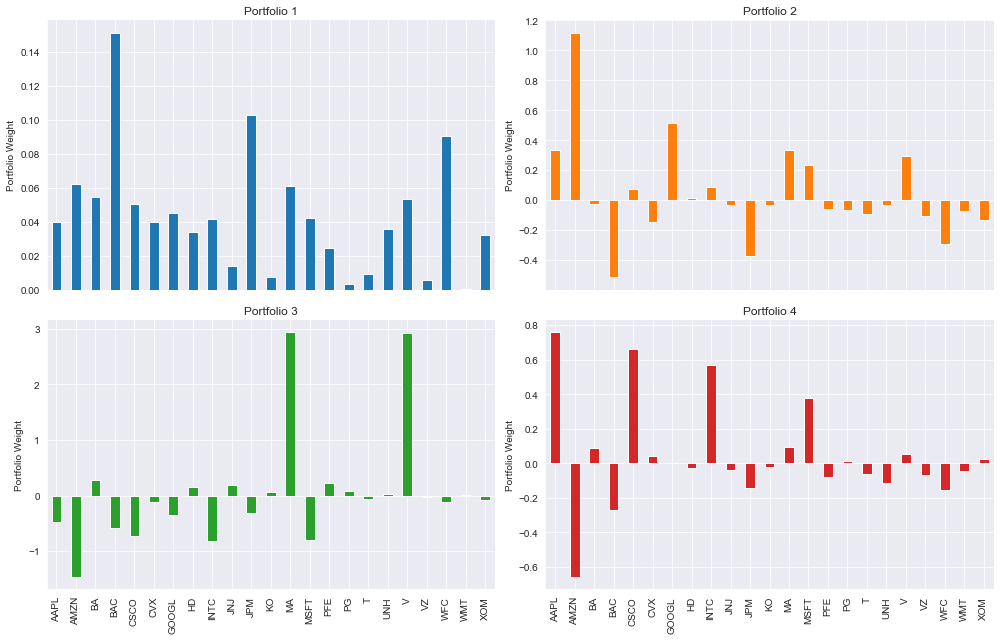

In [63]:
# Eigenportfolio Weights
axes = eigen_portfolios.T.plot.bar(subplots=True, layout=(2, 2), figsize=(14, 9), legend=False)
for ax in axes.flatten():
    ax.set_ylabel('Portfolio Weight')
    ax.set_xlabel('')
sns.despine()
plt.tight_layout()

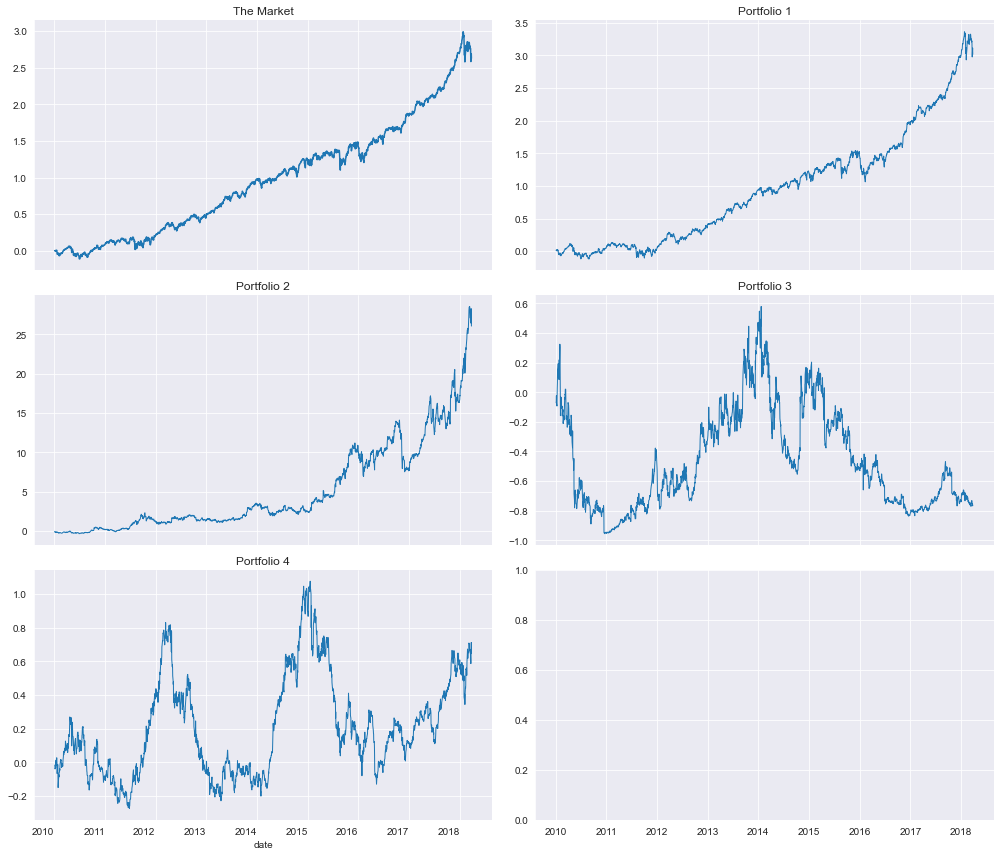

In [68]:
# Eigenportfolio Performance
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12), sharex=True)
axes = axes.flatten()
returns.mean(1).add(1).cumprod().sub(1).plot(title='The Market', ax=axes[0])
for i in range(4):
    rc = returns.mul(eigen_portfolios.iloc[i]).sum(1).add(1).cumprod().sub(1)
    rc.plot(title=f'Portfolio {i+1}', ax=axes[i+1], lw=1, rot=0)

for i in range(4):
    axes[i].set_xlabel('')
sns.despine()
fig.tight_layout()